# Multi-class classification task (intent classification) for banking77 dataset.

## Importing needed libraries, creation of functions and classes, loading data

In [1]:
# Install transformers library
!pip install transformers

In [2]:
# Import needed libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

%load_ext autoreload
%autoreload 2

In [3]:
# Load train and test data from banking77
#%%bash
#pip install transformers evaluate accelerate
!wget -q -nc "https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv"
!wget -q -nc "https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/test.csv"

In [4]:
# Define metric
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    f1 = f1_score(y_true=labels, y_pred=pred, average = 'macro')

    return {"f1_score_macro": f1}

In [5]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [6]:
# Load csv files
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')

## Exploration of data

In [7]:
# Check how data looks like: there is text column and category column; and check shape of data
train, test

(                                                    text         category
 0                         I am still waiting on my card?     card_arrival
 1      What can I do if my card still hasn't arrived ...     card_arrival
 2      I have been waiting over a week. Is the card s...     card_arrival
 3      Can I track my card while it is in the process...     card_arrival
 4      How do I know if I will get my card, or if it ...     card_arrival
 ...                                                  ...              ...
 9998              You provide support in what countries?  country_support
 9999                  What countries are you supporting?  country_support
 10000                What countries are getting support?  country_support
 10001                     Are cards available in the EU?  country_support
 10002                   Which countries are represented?  country_support
 
 [10003 rows x 2 columns],
                                                    text         catego

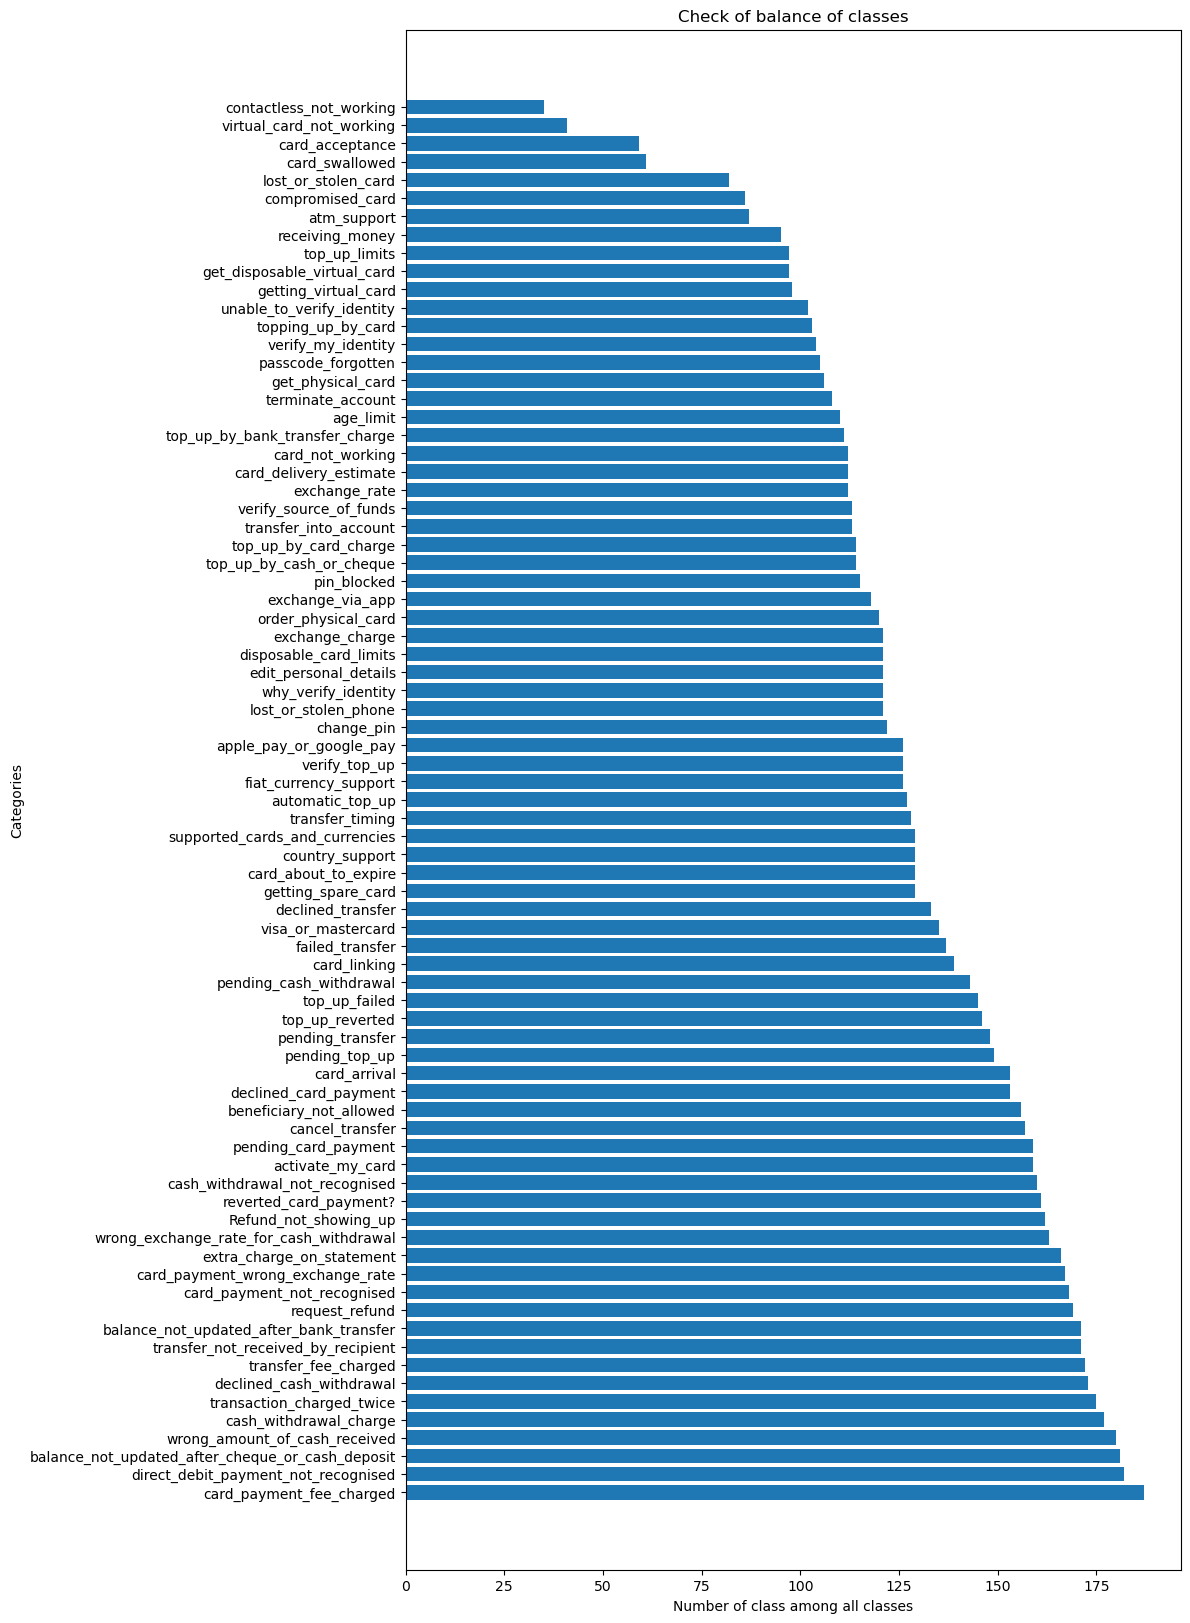

In [8]:
# Draw horizontal bar plot in order to check balance of classes
numbers_of_classes = train['category'].value_counts()

plt.figure(figsize=(10,20))

plt.barh(numbers_of_classes.index, numbers_of_classes.values)

plt.xlabel("Number of class among all classes")
plt.ylabel('Categories')
plt.title('Check of balance of classes', loc='center')
plt.show()

In [9]:
# Check number of classes and sum values for appearance of categories
print("The number of classes in categories is: {m}\n\n".format(m = len(numbers_of_classes)))

print("The head of dataset:\n {m}\n\n".format(m = numbers_of_classes.head(10)))
print("The tail of dataset:\n {m}".format(m = numbers_of_classes.tail(10)))

The number of classes in categories is: 77


The head of dataset:
 card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
transaction_charged_twice                           175
declined_cash_withdrawal                            173
transfer_fee_charged                                172
transfer_not_received_by_recipient                  171
balance_not_updated_after_bank_transfer             171
Name: category, dtype: int64


The tail of dataset:
 get_disposable_virtual_card    97
top_up_limits                  97
receiving_money                95
atm_support                    87
compromised_card               86
lost_or_stolen_card            82
card_swallowed                 61
card_acceptance                59
virtual_card_not_working       41
contactless_no

## Conclusions for EDA: 
### Data is presented in format of 2 columns: text and category (target). There are 77 classes of target (categories). Therefore the task is multiclass classification. Dataset is imbalanced: it should me taken in account when the metric will be specified.

## Modeling. Multi-class classification

#### As for the metric, F1 score with macro averaging is used. F1 score is popular metric for multi-class classification, it takes into account both precision and recall. Since dataset is imbalanced, macro averaging is used. All classes are equally important, macro averaging treats all classes equally.

In [10]:
# Transform data
train_text = train["text"]
train_category = train["category"]
test_text = test["text"]
test_category = test["category"]

# Divide on train and valid dataset
train_text, valid_text, train_category,valid_category= train_test_split(train_text, train_category, test_size=0.3,  random_state=1234)

# Check how many rows in datasets
print(f"There are {len(train_text)} rows in train data")
print(f"There are {len(test_text)} rows in test data")
print(f"There are {len(valid_text)} rows in validation data")

There are 7002 rows in train data
There are 3080 rows in test data
There are 3001 rows in validation data


In [11]:
# Create dictionary for categories
dict_with_categories = dict()
i = 0
for category in train_category.unique():
    dict_with_categories[category] = i
    i +=1
    
# Check disctionary
len(dict_with_categories), dict_with_categories

(77,
 {'receiving_money': 0,
  'exchange_rate': 1,
  'cash_withdrawal_charge': 2,
  'pin_blocked': 3,
  'declined_transfer': 4,
  'exchange_charge': 5,
  'exchange_via_app': 6,
  'verify_top_up': 7,
  'visa_or_mastercard': 8,
  'top_up_by_cash_or_cheque': 9,
  'pending_card_payment': 10,
  'reverted_card_payment?': 11,
  'declined_card_payment': 12,
  'verify_source_of_funds': 13,
  'unable_to_verify_identity': 14,
  'top_up_reverted': 15,
  'top_up_by_card_charge': 16,
  'balance_not_updated_after_cheque_or_cash_deposit': 17,
  'topping_up_by_card': 18,
  'cancel_transfer': 19,
  'edit_personal_details': 20,
  'balance_not_updated_after_bank_transfer': 21,
  'card_linking': 22,
  'supported_cards_and_currencies': 23,
  'direct_debit_payment_not_recognised': 24,
  'apple_pay_or_google_pay': 25,
  'automatic_top_up': 26,
  'change_pin': 27,
  'transfer_into_account': 28,
  'card_about_to_expire': 29,
  'wrong_amount_of_cash_received': 30,
  'top_up_failed': 31,
  'wrong_exchange_rate_fo

In [12]:
# Transform targets according to the dictionary
valid_category = list(valid_category.map(dict_with_categories))
train_category = list(train_category.map(dict_with_categories))
test_category = list(test_category.map(dict_with_categories))

In [13]:
# Loading the pre-trained BERT model from huggingface library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=77)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [14]:
# Tokenize train and valid data
train_text_tokenized = tokenizer(list(train_text), padding=True, truncation=True, max_length=512)
valid_text_tokenized = tokenizer(list(valid_text), padding=True, truncation=True, max_length=512)

# Create torch datasets
train_dataset = Dataset(train_text_tokenized, labels=train_category)
valid_dataset = Dataset(valid_text_tokenized, labels=valid_category)

In [15]:
# Define Trainer with parameters like batch size, number of epochs, etc.
training_args = TrainingArguments(
    output_dir="output_model",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    seed=1234,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [16]:
# Train pre-trained model
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1 Score Macro
1,No log,1.794405,0.648155
2,No log,0.768481,0.847310
3,2.036100,0.478674,0.893537
4,2.036100,0.389202,0.908540
5,0.312700,0.360302,0.917250


TrainOutput(global_step=1095, training_loss=1.0873041335850546, metrics={'train_runtime': 533.3241, 'train_samples_per_second': 65.645, 'train_steps_per_second': 2.053, 'total_flos': 1764329417033400.0, 'train_loss': 1.0873041335850546, 'epoch': 5.0})

In [17]:
# Save model
trainer.save_model("bert_model")

## Evaluation on test dataset

In [18]:
# Check how test data looks like
test_text

0                                How do I locate my card?
1       I still have not received my new card, I order...
2       I ordered a card but it has not arrived. Help ...
3        Is there a way to know when my card will arrive?
4                            My card has not arrived yet.
                              ...                        
3075        If i'm not in the UK, can I still get a card?
3076                   How many countries do you support?
3077                What countries do you do business in?
3078               What are the countries you operate in.
3079           Can the card be mailed and used in Europe?
Name: text, Length: 3080, dtype: object

In [19]:
# Tokenize test data
test_text_tokenized = tokenizer(list(test_text), padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(test_text_tokenized)

In [20]:
# Load and apply saved model
model_path = "bert_model"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=77)

test_trainer = Trainer(model)

In [21]:
# Get predictions and real targets
raw_pred, _, _ = test_trainer.predict(test_dataset)

y_pred = np.argmax(raw_pred, axis=1)
y_test = np.array(test_category)

# Compute f1 score with macro averaging on test data
f1_score(y_test, y_pred,  average='macro') 

0.919540435707599

## Forecasting of intents using model based on queries on banking topics

In [22]:
# See examples of queries on different categories in order to create new ones
train[train['category'] == 'edit_personal_details'], train[train['category'] == 'country_support'], train[train['category'] == 'lost_or_stolen_card']

(                                                   text               category
 3650   I am interested in changing my personal details.  edit_personal_details
 3651                     I am here to change my adress.  edit_personal_details
 3652  I'd like to make some changes to my personal i...  edit_personal_details
 3653     I would like to change my name after marriage.  edit_personal_details
 3654                   I would like to change my adress  edit_personal_details
 ...                                                 ...                    ...
 3766                        I need to change my address  edit_personal_details
 3767                 Where can I modify my information?  edit_personal_details
 3768                      How do I change my last name?  edit_personal_details
 3769                                I have a new email.  edit_personal_details
 3770         How can I update my details since I moved?  edit_personal_details
 
 [121 rows x 2 columns],
             

In [23]:
# Check numbers of categories
dict_with_categories['edit_personal_details'], dict_with_categories['country_support'], dict_with_categories['lost_or_stolen_card']

(20, 53, 76)

In [24]:
# Tokenize data of new queries
queries = ['How can I change my mobile phone information?', 'I am from Portugal. Do you have business in this country?', 'My card was stolen. Can you please help me?']
X_test_tokenized_1_query = tokenizer(queries, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset_1_query = Dataset(X_test_tokenized_1_query)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset_1_query)
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_pred

y_test = np.array([20, 53, 76])
y_test

# Compute f score with macro averaging
f1_score(y_test, y_pred,  average='macro')

1.0

In [25]:
# Check predictions. They are equal to real targets
y_pred

array([20, 53, 76])

## Conclusions:

### The pre-trained BERT model from huggingface library was used in this work to make multi-class classification with 77 classes. F1 score with macro averaging was chosen, the reason was mentioned above (there is imbalance in data, but classes are equally important).

 ### 1) On train and valid datasets model shows really good results: f1 score is high (more than 0.9) and cross-entropy loss is low (close to 0). Results can be improved with change of different parameters and hyperparameters: number of epochs, batch size, learning rate, etc.
 
 ### 2) On test data result were still good: f1 score with macro averaging is 0.92. This is good enough, because the closer the result is to one, the better.
 
 ### 3)  Forecasting of intents using model based on 3 queries on banking topics was successful (f1 score is 1). Model correctly classified all three queries on categories: 'edit_personal_details', 'country_support', 'lost_or_stolen_card'.